## Impact of denoising as one increases


In [1]:
#! lamin init --storage ./lamin-intro --schema bionty

import scanpy as sc
from scprint import scPrint
from scdataloader import Preprocessor
from scdataloader.utils import load_genes
import numpy as np
import anndata as ad
from huggingface_hub import hf_hub_download

from scprint.tasks import Denoiser, withknn
from scprint.model.utils import downsample_profile
from scipy.stats import spearmanr
from anndata import AnnData
from scprint.tasks.denoise import plot_cell_depth_wise_corr_improvement

import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

import torch

torch.set_float32_matmul_precision("medium")

/home/ml4ig1/Documents code/scPRINT/.venv/lib/python3.11/site-packages/louvain/__init__.py:54: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound


→ connected lamindb: jkobject/scprint_v2


/home/ml4ig1/Documents code/simpler_flash/src/simpler_flash/layer_norm.py:1044: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @custom_fwd
/home/ml4ig1/Documents code/simpler_flash/src/simpler_flash/layer_norm.py:1107: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  @custom_bwd


In [2]:
# model_checkpoint_file = hf_hub_download(
#    repo_id="jkobject/scPRINT", filename=f"v2-medium.ckpt"
# )
# model_checkpoint_file = ../data/
model_checkpoint_file = "../models/l2su2z5q.ckpt"
# w937u4o1

In [ ]:
model = scPrint.load_from_checkpoint(
    model_checkpoint_file, precpt_gene_emb=None, gene_pos_file=None
)
model = model.to("cuda")

FYI: scPrint is not attached to a `Trainer`.


: 

# run denoising as depth increase

In [6]:
#import lamindb as ln

#res = ln.Artifact.filter(uid="vhwQPOwZ3kyGtOv00001")[0]
#print(res.key)
#print(res.path)
#print()
#res = ln.Artifact.filter(uid="Q1fKksCKtOAgigiT0001")[0]
#print(res.key)
#print(res.path)

# 2025-02-25/h5ad/Velocyto/Homo_sapiens/SRX24486462.h5ad
# /pasteur/appa/scratch/jkalfon/scprint2/.lamindb/vhwQPOwZ3kyGtOv00001.h5ad

# 2025-02-25/h5ad/Velocyto/Homo_sapiens/SRX22526970.h5ad
# /pasteur/appa/scratch/jkalfon/scprint2/.lamindb/Q1fKksCKtOAgigiT0001.h5ad

In [2]:
LOC = "/pasteur/appa/scratch/jkalfon/data/spcrint_data/temp/"#"../../data/temp/"  #

datasets = {
    "retina": "https://datasets.cellxgene.cziscience.com/53bd4177-79c6-40c8-b84d-ff300dcf1b5b.h5ad",  # gNNpgpo6gATjuxTE7CCp
    "kidney": "https://datasets.cellxgene.cziscience.com/01bc7039-961f-4c24-b407-d535a2a7ba2c.h5ad",
    "pancreas": "https://figshare.com/ndownloader/files/24539828",
    "intestine": "https://datasets.cellxgene.cziscience.com/d9a99b4a-3755-47c4-8eb5-09821ffbde17.h5ad",  # R4ZHoQegxXdSFNFY5LGe in my case # R4ZHoQegxXdSFNFYMaIQ
    "glio_smart_highdepth": "https://datasets.cellxgene.cziscience.com/6ec440b4-542a-4022-ac01-56f812e25593.h5ad",  # s8x0Idi587LQtXCo0Pif
    "lung_smart": "https://datasets.cellxgene.cziscience.com/6ebba0e0-a159-406f-8095-451115673a2c.h5ad",
    # additional (see origin from block above)
    "SRX24486462": None,
    "SRX22526970": None,
    #
}

In [3]:
adata = sc.read(LOC + "SRX24486462" + ".h5ad", backup_url=datasets["intestine"])

In [ ]:
adata.X

array([  2.,   5.,   1.,  17., 462.,   1.,   2.,   1.,   2.,   1.],
      dtype=float32)

In [ ]:
what happens if 5000 everywhere?
what happens if we do on the entire dataset

doing  pancreas


X was not raw counts, using 'counts' layer
X was not raw counts, using 'counts' layer


/pasteur/appa/homes/jkalfon/scPRINT/.venv/lib/python3.11/site-packages/anndata/_core/anndata.py:602: FutureWarning: You are attempting to set `X` to a matrix on a view which has non-unique indices. The resulting `adata.X` will likely not equal the value to which you set it. To avoid this potential issue, please make a copy of the data first. In the future, this operation will throw an error.
  warnings.warn(msg, FutureWarning, stacklevel=1)


Dropping layers:  KeysView(LayersView with keys: counts)
checking raw counts
checking raw counts
Data is not raw counts, please check layers, find raw data, or bypass with force_preprocess
removed 0 non primary cells, 16382 renamining
Data is not raw counts, please check layers, find raw data, or bypass with force_preprocess
removed 0 non primary cells, 16382 renamining
filtered out 0 cells, 16382 renamining
filtered out 0 cells, 16382 renamining
Removed 1068 genes not known to the ontology
Removed 1068 genes not known to the ontology
Removed 0 duplicate genes
Added 52091 genes in the ontology but not present in the dataset
Removed 0 duplicate genes
Added 52091 genes in the ontology but not present in the dataset
starting QC
starting QC
Seeing 4678 outliers (28.55% of total dataset):
normalize
Seeing 4678 outliers (28.55% of total dataset):
normalize
starting PCA
starting PCA
done
AnnData object with n_obs × n_vars = 16382 × 70116
    obs: 'tech', 'celltype', 'size_factors', 'organism_

/pasteur/appa/homes/jkalfon/scdataloader/scdataloader/utils.py:427: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  organismdf = pd.concat(organismdf)


not on wandb, could not set name


100%|██████████| 250/250 [00:43<00:00,  5.81it/s]



logging the anndata
AnnData object with n_obs × n_vars = 5000 × 4936
    obs: 'pred_cell_type_ontology_term_id', 'pred_tissue_ontology_term_id', 'pred_disease_ontology_term_id', 'pred_assay_ontology_term_id', 'pred_self_reported_ethnicity_ontology_term_id', 'pred_sex_ontology_term_id', 'pred_organism_ontology_term_id', 'conv_pred_cell_type_ontology_term_id', 'conv_pred_tissue_ontology_term_id', 'conv_pred_disease_ontology_term_id', 'conv_pred_assay_ontology_term_id', 'conv_pred_self_reported_ethnicity_ontology_term_id'
    obsm: 'scprint_emb_cell_type_ontology_term_id'
    layers: 'scprint_mu', 'scprint_theta', 'scprint_pi'
AnnData object with n_obs × n_vars = 5000 × 4936
    obs: 'pred_cell_type_ontology_term_id', 'pred_tissue_ontology_term_id', 'pred_disease_ontology_term_id', 'pred_assay_ontology_term_id', 'pred_self_reported_ethnicity_ontology_term_id', 'pred_sex_ontology_term_id', 'pred_organism_ontology_term_id', 'conv_pred_cell_type_ontology_term_id', 'conv_pred_tissue_ontology_

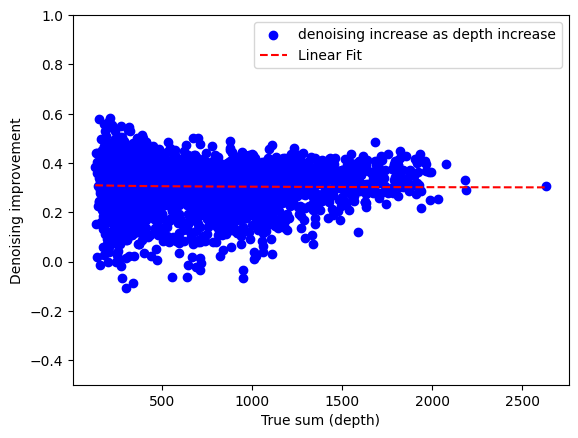

{'reco2noisy': 0.22648105857616874, 'reco2full': 0.7208670843144662, 'noisy2full': 0.4008832495135705}
(5000, 4936)
(5000, 4936)
Calculating MAGIC...
  Running MAGIC on 5000 cells and 4936 genes.
  Calculating graph and diffusion operator...
Calculating MAGIC...
  Running MAGIC on 5000 cells and 4936 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculating PCA...
    Calculated PCA in 1.48 seconds.
    Calculating KNN search...
    Calculated PCA in 1.48 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.35 seconds.
    Calculating affinities...
    Calculated KNN search in 0.35 seconds.
    Calculating affinities...
    Calculated affinities in 1.17 seconds.
  Calculated graph and diffusion operator in 3.02 seconds.
  Calculating imputation...
    Calculated affinities in 1.17 seconds.
  Calculated graph and diffusion operator in 3.02 seconds.
  Calculating imputation...
  Calculated imputation in 0.02 seconds.
  Calculated imputat

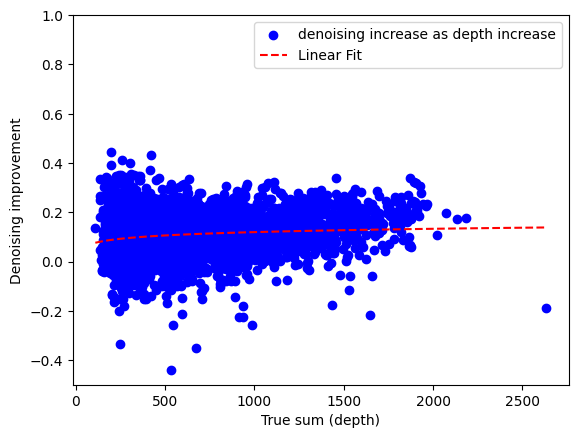

{'reco2noisy': 0.2604172236292821, 'reco2full': 0.5967120965066769, 'noisy2full': 0.4003175156609816}
--------------------------------



In [5]:
res = {}
for name, url in {"pancreas": "https://figshare.com/ndownloader/files/24539828",}.items():
    print("doing ", name)

    adata = sc.read(LOC + name + ".h5ad", backup_url=url)
    if "organism_ontology_term_id" not in adata.obs.columns.tolist():
        adata.obs["organism_ontology_term_id"] = "NCBITaxon:9606"  # assuming human if not specified
        is_symbol = True
    else:
        is_symbol = False
    max_len = 3000 if (adata.X > 0).sum(1).mean() < 2_000 else 5000
    preprocessor = Preprocessor(
        force_preprocess=True,
        skip_validate=True,
        is_symbol=is_symbol,
        # drop_non_primary=False,
        do_postp=model.expr_emb_style == "metacell",
    )
    print("")
    adata = adata[adata.X.sum(1) > 1000]
    adata = preprocessor(adata)
    if model.expr_emb_style == "metacell":
        sc.pp.neighbors(adata, use_rep="X_pca")
    print(adata.X.sum(1).mean())
    adata.layers["true"] = adata.X.copy()
    denoise = Denoiser(
        batch_size=40 if (adata.X > 0).sum(1).mean() < 2_000 else 20,
        max_len=max_len,
        max_cells=5_000,
        doplot=False,
        num_workers=8,
        predict_depth_mult=10,
        downsample_expr=0.7,
        additional_info=True,
        apply_zero_pred=True,
    )
    res["scprint_" + name], idx, nadata = denoise(model, adata)
    print(res["scprint_" + name])

    # doing magic
    subadata = (
        adata[idx, adata.var.index.isin(model.genes) & adata.var.highly_variable].copy()
        if idx is not None
        else adata[
            :, adata.var.index.isin(model.genes) & adata.var.highly_variable
        ].copy()
    )
    print(subadata.shape)
    subadata.X = downsample_profile(torch.Tensor(subadata.X.toarray()), 0.7)
    denoised_adata = sc.external.pp.magic(
        subadata.copy(), copy=True, n_jobs=10, solver="approximate", verbose=True
    )

    reco = denoised_adata.X
    true = subadata.layers["true"].toarray()
    noisy = subadata.X
    corr_coef, p_value = spearmanr(
        np.vstack([reco[true != 0], noisy[true != 0], true[true != 0]]).T
    )
    res["magic_" + name] = {
        "reco2noisy": corr_coef[0, 1],
        "reco2full": corr_coef[0, 2],
        "noisy2full": corr_coef[1, 2],
    }
    if reco.shape[0] >= 3000:
        indices = np.random.choice(reco.shape[0], 3000, replace=False)
        reco = reco[indices]
        noisy = noisy[indices]
        true = true[indices]
    corr, p_value = spearmanr(
        np.vstack(
            [
                reco.flatten(),
                noisy.flatten(),
                true.flatten(),
            ]
        ).T
    )
    m = {
        "reco2full": corr[0, 2],
        "noisy2full": corr[1, 2],
    }
    print("corr with zeros: ")
    print(m)
    cell_wise = np.array(
        [
            spearmanr(reco[i][true[i] != 0], true[i][true[i] != 0])[0]
            for i in range(reco.shape[0])
        ]
    )
    torm = np.array(
        [
            spearmanr(noisy[i][true[i] != 0], true[i][true[i] != 0])[0]
            for i in range(reco.shape[0])
        ]
    )
    cell_wise -= torm
    cell_wise_zero = np.mean(
        [spearmanr(reco[i], true[i])[0] for i in range(reco.shape[0])]
    )
    print("cell_wise self corr (reco, noisy, true)")
    print(
        {
            "cell_wise_w_zero": cell_wise_zero,
            "cell_wise_to_noisy": np.mean(cell_wise),
        }
    )
    print("depth-wise plot")
    plot_cell_depth_wise_corr_improvement(cell_wise, (true > 0).sum(1))
    print(res["magic_" + name])
    print("--------------------------------")
    print("")


In [6]:
res

{'scprint_pancreas': {'reco2noisy': 0.22648105857616874,
  'reco2full': 0.7208670843144662,
  'noisy2full': 0.4008832495135705},
 'magic_pancreas': {'reco2noisy': 0.2604172236292821,
  'reco2full': 0.5967120965066769,
  'noisy2full': 0.4003175156609816}}

In [ ]:
res = {}
for name, url in datasets.items():
    print("doing ", name)

    adata = sc.read(LOC + name + ".h5ad", backup_url=url)
    max_len = 3000 if (adata.X > 0).sum(1).mean() < 2_000 else 5000
    preprocessor = Preprocessor(
        force_preprocess=True,
        skip_validate=True,
        # drop_non_primary=False,
        do_postp=model.expr_emb_style == "metacell",
    )
    print("")
    adata = adata[adata.X.sum(1) > 1000]
    adata = preprocessor(adata)
    if model.expr_emb_style == "metacell":
        sc.pp.neighbors(adata, use_rep="X_pca")
    print(adata.X.sum(1).mean())
    adata.layers["true"] = adata.X.copy()
    denoise = Denoiser(
        batch_size=40 if (adata.X > 0).sum(1).mean() < 2_000 else 20,
        max_len=max_len,
        max_cells=5_000,
        doplot=False,
        num_workers=8,
        predict_depth_mult=10,
        downsample_expr=0.7,
        additional_info=True,
        apply_zero_pred=True,
    )
    res["scprint_" + name], idx, nadata = denoise(model, adata)
    print(res["scprint_" + name])

    # doing magic
    subadata = (
        adata[idx, adata.var.index.isin(model.genes) & adata.var.highly_variable].copy()
        if idx is not None
        else adata[
            :, adata.var.index.isin(model.genes) & adata.var.highly_variable
        ].copy()
    )
    print(subadata.shape)
    subadata.X = downsample_profile(torch.Tensor(subadata.X.toarray()), 0.7)
    denoised_adata = sc.external.pp.magic(
        subadata.copy(), copy=True, n_jobs=10, solver="approximate", verbose=True
    )

    reco = denoised_adata.X
    true = subadata.layers["true"].toarray()
    noisy = subadata.X
    corr_coef, p_value = spearmanr(
        np.vstack([reco[true != 0], noisy[true != 0], true[true != 0]]).T
    )
    res["magic_" + name] = {
        "reco2noisy": corr_coef[0, 1],
        "reco2full": corr_coef[0, 2],
        "noisy2full": corr_coef[1, 2],
    }
    if reco.shape[0] <= 3000:
        indices = np.random.choice(reco.shape[0], 3000, replace=False)
        reco = reco[indices]
        noisy = noisy[indices]
        true = true[indices]
    corr, p_value = spearmanr(
        np.vstack(
            [
                reco.flatten(),
                noisy.flatten(),
                true.flatten(),
            ]
        ).T
    )
    m = {
        "reco2full": corr[0, 2],
        "noisy2full": corr[1, 2],
    }
    print("corr with zeros: ")
    print(m)
    cell_wise = np.array(
        [
            spearmanr(reco[i][true[i] != 0], true[i][true[i] != 0])[0]
            for i in range(reco.shape[0])
        ]
    )
    torm = np.array(
        [
            spearmanr(noisy[i][true[i] != 0], true[i][true[i] != 0])[0]
            for i in range(reco.shape[0])
        ]
    )
    cell_wise -= torm
    cell_wise_zero = np.mean(
        [spearmanr(reco[i], true[i])[0] for i in range(reco.shape[0])]
    )
    print("cell_wise self corr (reco, noisy, true)")
    print(
        {
            "cell_wise_w_zero": cell_wise_zero,
            "cell_wise_to_noisy": np.mean(cell_wise),
        }
    )
    print("depth-wise plot")
    plot_cell_depth_wise_corr_improvement(cell_wise, (true > 0).sum(1))
    print(res["magic_" + name])
    print("--------------------------------")
    print("")


doing  retina



/pasteur/appa/homes/jkalfon/scPRINT/.venv/lib/python3.11/site-packages/anndata/_core/anndata.py:602: FutureWarning: You are attempting to set `X` to a matrix on a view which has non-unique indices. The resulting `adata.X` will likely not equal the value to which you set it. To avoid this potential issue, please make a copy of the data first. In the future, this operation will throw an error.
  warnings.warn(msg, FutureWarning, stacklevel=1)


Dropping layers:  KeysView(Layers with keys: )
checking raw counts
removed 0 non primary cells, 51531 renamining
filtered out 0 cells, 51531 renamining
Removed 0 genes not known to the ontology
Removed 0 duplicate genes
Added 33737 genes in the ontology but not present in the dataset
starting QC
Seeing 24011 outliers (46.59% of total dataset):
normalize
starting PCA


In [9]:
res

{'scprint_retina': {'reco2noisy': 0.12835546418504326,
  'reco2full': 0.634676338338404,
  'noisy2full': 0.3754403325655061},
 'magic_retina': {'reco2noisy': 0.28661029362155677,
  'reco2full': 0.6619770104132843,
  'noisy2full': 0.37624206798491955},
 'scprint_kidney': {'reco2noisy': 0.16448473097425817,
  'reco2full': 0.6271697467409807,
  'noisy2full': 0.36493137370647466},
 'magic_kidney': {'reco2noisy': 0.2494145736892564,
  'reco2full': 0.6115572201518081,
  'noisy2full': 0.36178533343045804},
 'scprint_glio_smart_highdepth': {'reco2noisy': 0.36720441107122964,
  'reco2full': 0.8022288884150133,
  'noisy2full': 0.4132499769357176},
 'magic_glio_smart_highdepth': {'reco2noisy': 0.23311556742027326,
  'reco2full': 0.5357117574462856,
  'noisy2full': 0.4113662839365645},
 'scprint_lung_smart': {'reco2noisy': 0.37105622367144786,
  'reco2full': 0.8448493043916464,
  'noisy2full': 0.40579962356208504},
 'magic_lung_smart': {'reco2noisy': 0.27777249795864106,
  'reco2full': 0.655123709

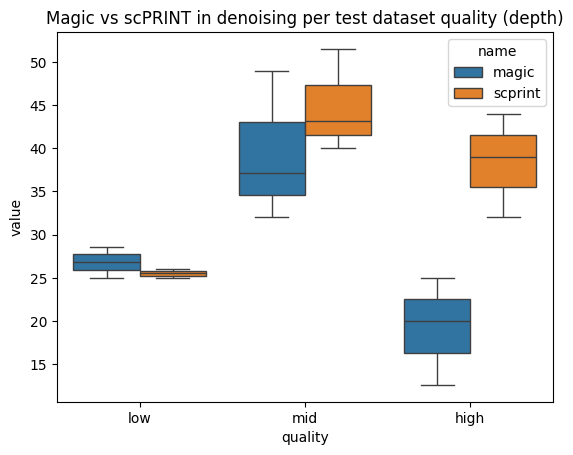

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.optimize import curve_fit

# Create a DataFrame
# from prevmodel
# data = {
#    'depth': [2736, 1888, 388362, 10360],
#    'magic': [30.4, 26.3, 6.4, 27.0],
#    'scprint': [19.3, 21.5, 33.2, 36.1]
# }
# from the prevmodel
#data = {
#    "depth": [1888, 2736, 388362, 10360, 21693, 38469],
#    "magic": [25, 28.7, 17.6, 27.6, 49, 37.1],
#    "scprint": [26, 27.6, 29.8, 28.2, 47.7, 37.1],
#}

data = {
    "depth":   [3_800, 5_300, 13_000, 21693, 38469, 140_000, 390_000, 1_000_000],
    "magic":   [25,    28.6,  32,     49,    37.1,  20,      12.6,    25],
    "scprint": [26,    25,    40,     51.5,  43.1,  32,      39,      44],
    "quality": ["low", "low", "mid", "mid", "mid", "high", "high", "high"],
}

# smart-seq: 25-44 & 13-39

df = pd.DataFrame(data)
df = df.melt(id_vars=["quality"], value_vars=["magic", "scprint"], var_name="name", value_name="value")
sns.boxplot(data=df, x="quality", y="value", hue="name")


# Add labels and legend
plt.title("Magic vs scPRINT denoising per test dataset quality (depth)")
plt.show()

In [47]:
from scipy.stats import mannwhitneyu
from statistics import mean

for elem in [[[25,28],[26,25]],[[32,49,37],[40,51,43]],[[20,12, 25],[32,39, 44]]]:
    statistic, pvalue = mannwhitneyu(elem[0], elem[1], alternative='two-sided')
    m1 = mean(elem[0])#.mean()
    m2 = mean(elem[1])
    fold_change = m2 / m1 if m1 != 0 else np.inf
    print(f"Statistic: {statistic}, P-value: {pvalue}, Fold Change: {fold_change}")


Statistic: 2.5, P-value: 1.0, Fold Change: 0.9622641509433962
Statistic: 2.0, P-value: 0.4, Fold Change: 1.135593220338983
Statistic: 0.0, P-value: 0.1, Fold Change: 2.017543859649123


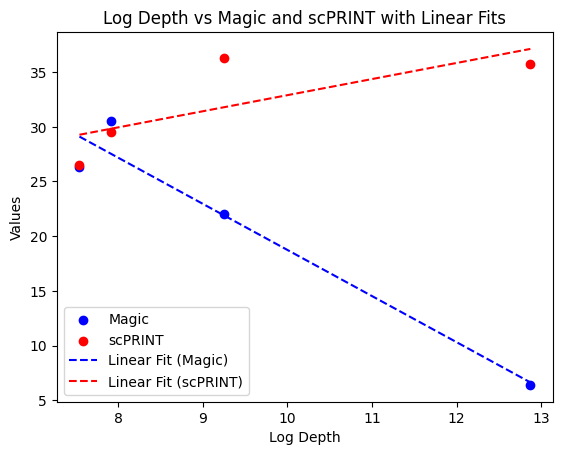

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

# Create a DataFrame
# from prevmodel
# data = {
#    'depth': [2736, 1888, 388362, 10360],
#    'magic': [30.4, 26.3, 6.4, 27.0],
#    'scprint': [19.3, 21.5, 33.2, 36.1]
# }
data = {
    "depth": [2736, 1888, 388362, 10360],
    "magic": [30.5, 26.3, 6.4, 22.0],
    "scprint": [29.5, 26.5, 35.7, 36.3],
}
df = pd.DataFrame(data)

# Convert depth to log scale
df["log_depth"] = np.log(df["depth"])


# Define a linear function for curve fitting
def linear_func(x, a, b):
    return a * x + b


# Fit the linear curves on log scale
popt_magic, _ = curve_fit(linear_func, df["log_depth"], df["magic"])
popt_scprint, _ = curve_fit(linear_func, df["log_depth"], df["scprint"])

# Plot the data points
plt.scatter(df["log_depth"], df["magic"], label="Magic", color="blue")
plt.scatter(df["log_depth"], df["scprint"], label="scPRINT", color="red")

# Plot the fitted linear curves
x_values = np.linspace(min(df["log_depth"]), max(df["log_depth"]), 100)
plt.plot(
    x_values,
    linear_func(x_values, *popt_magic),
    label="Linear Fit (Magic)",
    color="blue",
    linestyle="--",
)
plt.plot(
    x_values,
    linear_func(x_values, *popt_scprint),
    label="Linear Fit (scPRINT)",
    color="red",
    linestyle="--",
)

# Add labels and legend
plt.xlabel("Log Depth")
plt.ylabel("Values")
plt.legend()
plt.title("Log Depth vs Magic and scPRINT with Linear Fits")
plt.show()


2498.7604421298756 10360.862 9409


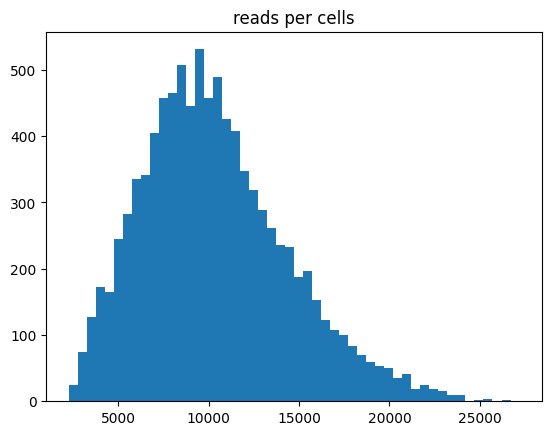

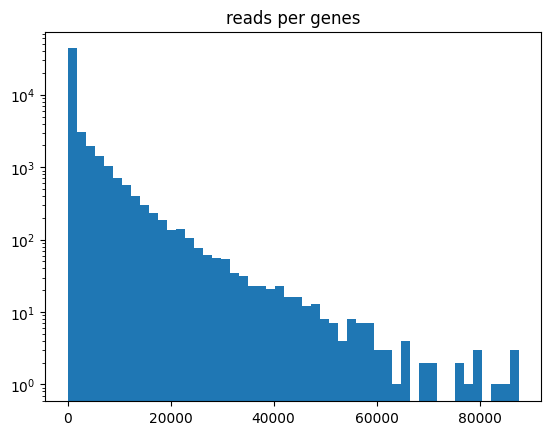

In [10]:
adata = sc.read(LOC + "lung_smart" + ".h5ad")
print((adata.X > 0).sum(1).mean(), adata.X.sum(1).mean(), adata.shape[0])
plt.hist(np.array(adata.X.sum(1)).T[0], bins=50)
plt.title("reads per cells")
plt.show()
plt.hist(np.array(adata.X.sum(0))[0], bins=50)
plt.yscale("log")
plt.title("reads per genes")
plt.show()
# 4x

2510.0482028420174 388362.5 3589


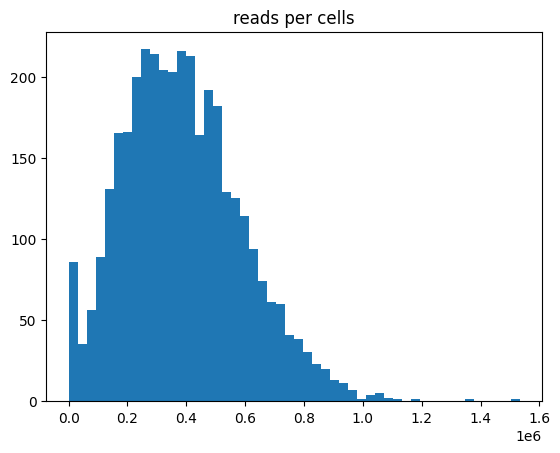

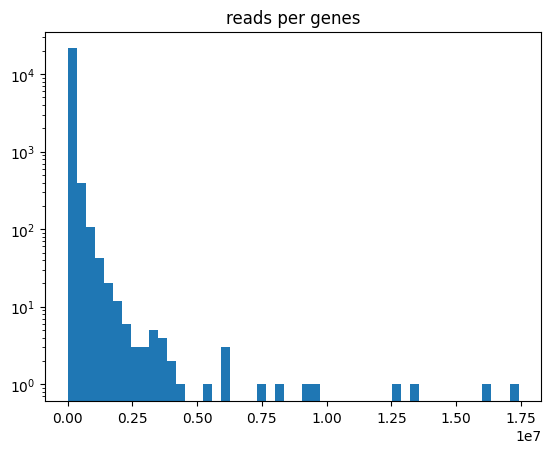

In [11]:
adata = sc.read(LOC + "glio_smart_highdepth" + ".h5ad")
print((adata.X > 0).sum(1).mean(), adata.X.sum(1).mean(), adata.shape[0])
plt.hist(np.array(adata.X.sum(1)).T[0], bins=50)
plt.title("reads per cells")
plt.show()
plt.hist(np.array(adata.X.sum(0))[0], bins=50)
plt.yscale("log")
plt.title("reads per genes")
plt.show()
# 14x

5190.719223565469 38469.57 5873


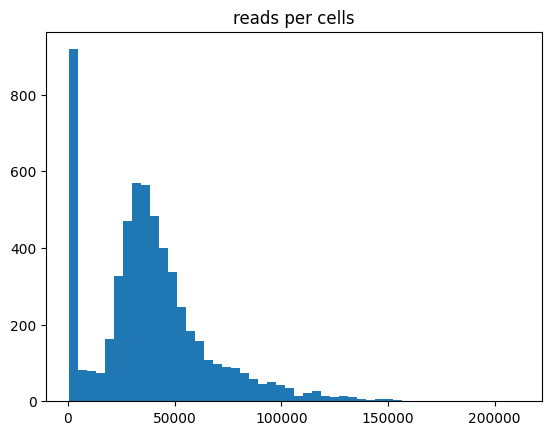

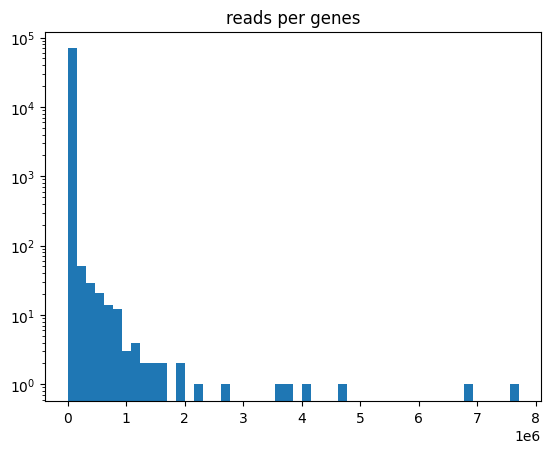

In [12]:
adata = sc.read(LOC + "SRX24486462" + ".h5ad")
print((adata.X > 0).sum(1).mean(), adata.X.sum(1).mean(), adata.shape[0])
plt.hist(np.array(adata.X.sum(1)).T[0], bins=50)
plt.title("reads per cells")
plt.show()
plt.hist(np.array(adata.X.sum(0))[0], bins=50)
plt.yscale("log")
plt.title("reads per genes")
plt.show()
# 7x

4145.619956883277 21693.55 3247


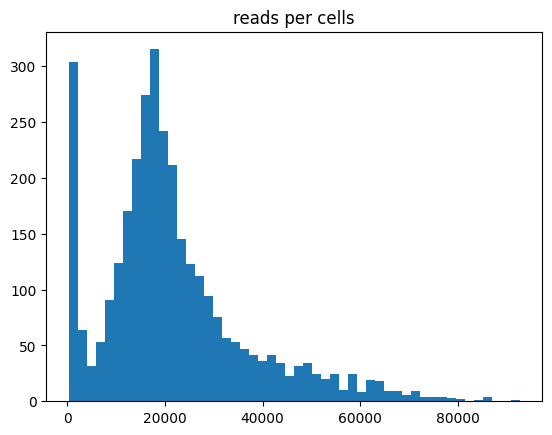

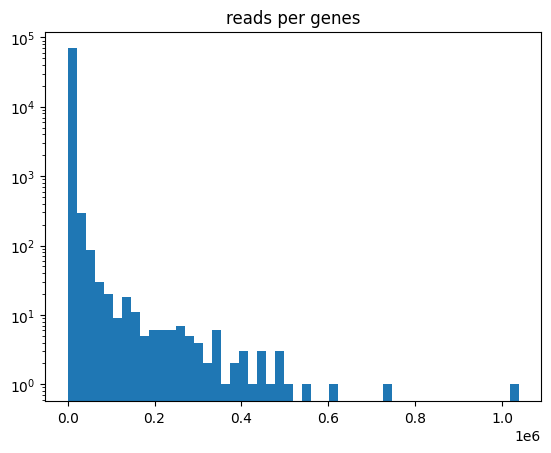

In [13]:
adata = sc.read(LOC + "SRX22526970" + ".h5ad")
print((adata.X > 0).sum(1).mean(), adata.X.sum(1).mean(), adata.shape[0])
plt.hist(np.array(adata.X.sum(1)).T[0], bins=50)
plt.title("reads per cells")
plt.show()
plt.hist(np.array(adata.X.sum(0))[0], bins=50)
plt.title("reads per genes")
plt.yscale("log")
plt.show()
# 5x

1982.6642332040024 1888.9308 39176


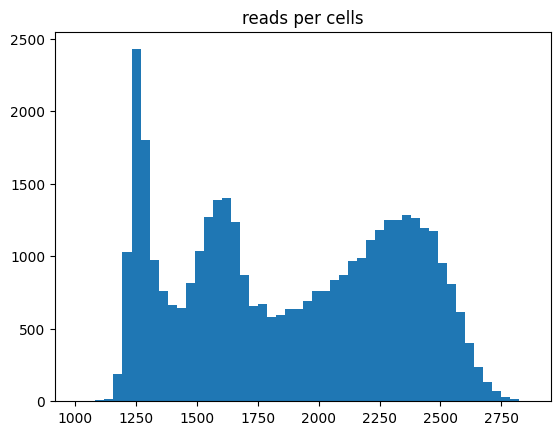

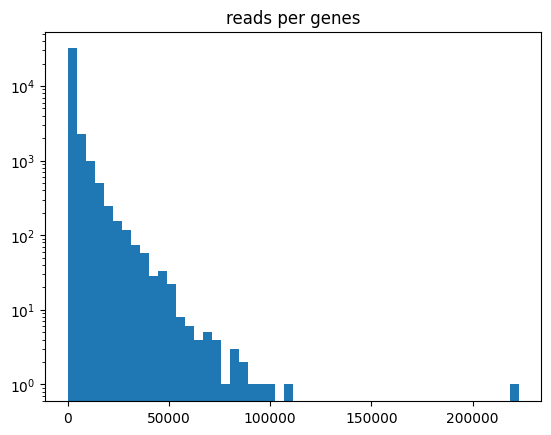

In [14]:
adata = sc.read(LOC + "kidney" + ".h5ad")
print((adata.X > 0).sum(1).mean(), adata.X.sum(1).mean(), adata.shape[0])
plt.hist(np.array(adata.X.sum(1)).T[0], bins=50)
plt.title("reads per cells")
plt.show()
plt.hist(np.array(adata.X.sum(0))[0], bins=50)
plt.title("reads per genes")
plt.yscale("log")
plt.show()
# 1x

In [15]:
adata = sc.read(LOC + "lung_smart" + ".h5ad")

In [16]:
preprocessor = Preprocessor(
    force_preprocess=True, skip_validate=True, drop_non_primary=False, do_postp=False
)
preprocessor = Preprocessor(do_postp=False)
adata = preprocessor(adata)
adata.layers["true"] = adata.X.copy()

Dropping layers:  KeysView(Layers with keys: )
checking raw counts


removed 0 non primary cells, 9409 renamining


filtered out 0 cells, 9409 renamining


Removed 0 genes not known to the ontology


Removed 0 duplicate genes
Added 15701 genes in the ontology but not present in the dataset


starting QC


Seeing 5471 outliers (58.14% of total dataset):


done
AnnData object with n_obs × n_vars = 9409 × 70116
    obs: 'nGene', 'nReads', 'plate.barcode', 'cell.id', 'region', 'label', 'sorter', 'sort.location', 'sample', 'location', 'donor_id', 'percent.ercc', 'percent.ribo', 'gating', 'free_annotation', 'Number of splices: Total', 'Number of splices: Annotated (sjdb)', 'Number of splices: GT-AG', 'Number of splices: GC-AG', 'Number of splices: AT-AC', 'Number of splices: Non-canonical', 'Mapping speed, Million of reads per hour', 'Average input read length', 'compartment', 'tissue_ontology_term_id', 'disease_ontology_term_id', 'development_stage_ontology_term_id', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'sex_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'suspension_type', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid', 'nnz', 'n_genes', 'n_genes_by_counts', 'lo

In [17]:
denoise = Denoiser(
    batch_size=40 if adata.X.sum(1).mean() < 50_000 else 20,
    max_len=8_000,
    max_cells=100_000,
    doplot=False,
    num_workers=8,
    predict_depth_mult=5,
    downsample_expr=0.7,
)

In [18]:
_, idx, nadata = denoise(model, adata)

working on 4288 accepted genes


/pasteur/appa/homes/jkalfon/scdataloader/scdataloader/utils.py:427: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  organismdf = pd.concat(organismdf)


not on wandb, could not set name



  0%|          | 0/471 [00:00<?, ?it/s]


  0%|          | 1/471 [00:01<11:11,  1.43s/it]


  0%|          | 2/471 [00:01<05:28,  1.43it/s]


  1%|          | 3/471 [00:01<03:36,  2.16it/s]


  1%|          | 4/471 [00:01<02:44,  2.84it/s]


  1%|          | 5/471 [00:02<02:14,  3.46it/s]


  1%|▏         | 6/471 [00:02<01:57,  3.97it/s]


  1%|▏         | 7/471 [00:02<01:45,  4.39it/s]


  2%|▏         | 8/471 [00:02<01:38,  4.69it/s]


  2%|▏         | 9/471 [00:02<01:33,  4.92it/s]


  2%|▏         | 10/471 [00:03<01:30,  5.10it/s]


  2%|▏         | 11/471 [00:03<01:27,  5.26it/s]


  3%|▎         | 12/471 [00:03<01:26,  5.33it/s]


  3%|▎         | 13/471 [00:03<01:25,  5.38it/s]


  3%|▎         | 14/471 [00:03<01:24,  5.42it/s]


  3%|▎         | 15/471 [00:03<01:23,  5.43it/s]


  3%|▎         | 16/471 [00:04<01:23,  5.44it/s]


  4%|▎         | 17/471 [00:04<01:22,  5.49it/s]


  4%|▍         | 18/471 [00:04<01:21,  5.53it/s]


  4%|▍         | 19/471 [00:04<01:22,  5.50it/s]


  4%|▍         | 20/471 [00:04<01:22,  5.48it/s]


  4%|▍         | 21/471 [00:05<01:21,  5.51it/s]


  5%|▍         | 22/471 [00:05<01:20,  5.56it/s]


  5%|▍         | 23/471 [00:05<01:21,  5.50it/s]


  5%|▌         | 24/471 [00:05<01:20,  5.54it/s]


  5%|▌         | 25/471 [00:05<01:20,  5.52it/s]


  6%|▌         | 26/471 [00:05<01:19,  5.59it/s]


  6%|▌         | 27/471 [00:06<01:40,  4.40it/s]


  6%|▌         | 28/471 [00:06<01:35,  4.63it/s]


  6%|▌         | 29/471 [00:06<01:31,  4.81it/s]


  6%|▋         | 30/471 [00:06<01:27,  5.02it/s]


  7%|▋         | 31/471 [00:07<01:24,  5.18it/s]


  7%|▋         | 32/471 [00:07<01:22,  5.31it/s]


  7%|▋         | 33/471 [00:07<01:21,  5.39it/s]


  7%|▋         | 34/471 [00:07<01:20,  5.46it/s]


  7%|▋         | 35/471 [00:07<01:19,  5.50it/s]


  8%|▊         | 36/471 [00:07<01:20,  5.41it/s]


  8%|▊         | 37/471 [00:08<01:19,  5.46it/s]


  8%|▊         | 38/471 [00:08<01:18,  5.52it/s]


  8%|▊         | 39/471 [00:08<01:19,  5.40it/s]


  8%|▊         | 40/471 [00:08<01:21,  5.32it/s]


  9%|▊         | 41/471 [00:08<01:20,  5.37it/s]


  9%|▉         | 42/471 [00:09<01:18,  5.48it/s]


  9%|▉         | 43/471 [00:09<01:17,  5.49it/s]


  9%|▉         | 44/471 [00:09<01:17,  5.53it/s]


 10%|▉         | 45/471 [00:09<01:16,  5.56it/s]


 10%|▉         | 46/471 [00:09<01:16,  5.55it/s]


 10%|▉         | 47/471 [00:09<01:16,  5.57it/s]


 10%|█         | 48/471 [00:10<01:15,  5.59it/s]


 10%|█         | 49/471 [00:10<01:15,  5.56it/s]


 11%|█         | 50/471 [00:10<01:15,  5.60it/s]


 11%|█         | 51/471 [00:10<01:14,  5.60it/s]


 11%|█         | 52/471 [00:10<01:15,  5.57it/s]


 11%|█▏        | 53/471 [00:10<01:14,  5.59it/s]


 11%|█▏        | 54/471 [00:11<01:14,  5.60it/s]


 12%|█▏        | 55/471 [00:11<01:16,  5.43it/s]


 12%|█▏        | 56/471 [00:11<01:15,  5.48it/s]


 12%|█▏        | 57/471 [00:11<01:15,  5.52it/s]


 12%|█▏        | 58/471 [00:11<01:14,  5.52it/s]


 13%|█▎        | 59/471 [00:12<01:14,  5.56it/s]


 13%|█▎        | 60/471 [00:12<01:13,  5.58it/s]


 13%|█▎        | 61/471 [00:12<01:13,  5.58it/s]


 13%|█▎        | 62/471 [00:12<01:13,  5.58it/s]


 13%|█▎        | 63/471 [00:12<01:12,  5.59it/s]


 14%|█▎        | 64/471 [00:12<01:12,  5.59it/s]


 14%|█▍        | 65/471 [00:13<01:12,  5.59it/s]


 14%|█▍        | 66/471 [00:13<01:12,  5.59it/s]


 14%|█▍        | 67/471 [00:13<01:12,  5.59it/s]


 14%|█▍        | 68/471 [00:13<01:12,  5.59it/s]


 15%|█▍        | 69/471 [00:13<01:11,  5.60it/s]


 15%|█▍        | 70/471 [00:14<01:11,  5.58it/s]


 15%|█▌        | 71/471 [00:14<01:11,  5.59it/s]


 15%|█▌        | 72/471 [00:14<01:11,  5.59it/s]


 15%|█▌        | 73/471 [00:14<01:11,  5.58it/s]


 16%|█▌        | 74/471 [00:14<01:11,  5.58it/s]


 16%|█▌        | 75/471 [00:14<01:10,  5.59it/s]


 16%|█▌        | 76/471 [00:15<01:10,  5.58it/s]


 16%|█▋        | 77/471 [00:15<01:10,  5.58it/s]


 17%|█▋        | 78/471 [00:15<01:10,  5.58it/s]


 17%|█▋        | 79/471 [00:15<01:10,  5.58it/s]


 17%|█▋        | 80/471 [00:15<01:10,  5.57it/s]


 17%|█▋        | 81/471 [00:16<01:09,  5.58it/s]


 17%|█▋        | 82/471 [00:16<01:09,  5.58it/s]


 18%|█▊        | 83/471 [00:16<01:09,  5.58it/s]


 18%|█▊        | 84/471 [00:16<01:09,  5.58it/s]


 18%|█▊        | 85/471 [00:16<01:09,  5.57it/s]


 18%|█▊        | 86/471 [00:16<01:09,  5.57it/s]


 18%|█▊        | 87/471 [00:17<01:08,  5.57it/s]


 19%|█▊        | 88/471 [00:17<01:08,  5.57it/s]


 19%|█▉        | 89/471 [00:17<01:08,  5.57it/s]


 19%|█▉        | 90/471 [00:17<01:08,  5.57it/s]


 19%|█▉        | 91/471 [00:17<01:08,  5.57it/s]


 20%|█▉        | 92/471 [00:18<01:08,  5.57it/s]


 20%|█▉        | 93/471 [00:18<01:07,  5.57it/s]


 20%|█▉        | 94/471 [00:18<01:07,  5.57it/s]


 20%|██        | 95/471 [00:18<01:07,  5.57it/s]


 20%|██        | 96/471 [00:18<01:07,  5.57it/s]


 21%|██        | 97/471 [00:18<01:07,  5.57it/s]


 21%|██        | 98/471 [00:19<01:06,  5.57it/s]


 21%|██        | 99/471 [00:19<01:07,  5.52it/s]


 21%|██        | 100/471 [00:19<01:07,  5.52it/s]


 21%|██▏       | 101/471 [00:19<01:07,  5.49it/s]


 22%|██▏       | 102/471 [00:19<01:07,  5.50it/s]


 22%|██▏       | 103/471 [00:19<01:07,  5.48it/s]


 22%|██▏       | 104/471 [00:20<01:06,  5.50it/s]


 22%|██▏       | 105/471 [00:20<01:07,  5.45it/s]


 23%|██▎       | 106/471 [00:20<01:06,  5.47it/s]


 23%|██▎       | 107/471 [00:20<01:06,  5.45it/s]


 23%|██▎       | 108/471 [00:20<01:06,  5.48it/s]


 23%|██▎       | 109/471 [00:21<01:06,  5.46it/s]


 23%|██▎       | 110/471 [00:21<01:05,  5.48it/s]


 24%|██▎       | 111/471 [00:21<01:06,  5.45it/s]


 24%|██▍       | 112/471 [00:21<01:05,  5.47it/s]


 24%|██▍       | 113/471 [00:21<01:05,  5.44it/s]


 24%|██▍       | 114/471 [00:22<01:05,  5.47it/s]


 24%|██▍       | 115/471 [00:22<01:05,  5.45it/s]


 25%|██▍       | 116/471 [00:22<01:04,  5.48it/s]


 25%|██▍       | 117/471 [00:22<01:05,  5.44it/s]


 25%|██▌       | 118/471 [00:22<01:04,  5.46it/s]


 25%|██▌       | 119/471 [00:22<01:04,  5.44it/s]


 25%|██▌       | 120/471 [00:23<01:04,  5.48it/s]


 26%|██▌       | 121/471 [00:23<01:04,  5.44it/s]


 26%|██▌       | 122/471 [00:23<01:03,  5.46it/s]


 26%|██▌       | 123/471 [00:23<01:04,  5.43it/s]


 26%|██▋       | 124/471 [00:23<01:03,  5.45it/s]


 27%|██▋       | 125/471 [00:24<01:03,  5.44it/s]


 27%|██▋       | 126/471 [00:24<01:03,  5.46it/s]


 27%|██▋       | 127/471 [00:24<01:03,  5.44it/s]


 27%|██▋       | 128/471 [00:24<01:02,  5.46it/s]


 27%|██▋       | 129/471 [00:24<01:03,  5.43it/s]


 28%|██▊       | 130/471 [00:24<01:02,  5.45it/s]


 28%|██▊       | 131/471 [00:25<01:02,  5.43it/s]


 28%|██▊       | 132/471 [00:25<01:02,  5.45it/s]


 28%|██▊       | 133/471 [00:25<01:02,  5.43it/s]


 28%|██▊       | 134/471 [00:25<01:01,  5.45it/s]


 29%|██▊       | 135/471 [00:25<01:03,  5.30it/s]


 29%|██▉       | 136/471 [00:26<01:02,  5.35it/s]


 29%|██▉       | 137/471 [00:26<01:02,  5.36it/s]


 29%|██▉       | 138/471 [00:26<01:01,  5.40it/s]


 30%|██▉       | 139/471 [00:26<01:01,  5.38it/s]


 30%|██▉       | 140/471 [00:26<01:01,  5.41it/s]


 30%|██▉       | 141/471 [00:26<01:01,  5.39it/s]


 30%|███       | 142/471 [00:27<01:00,  5.41it/s]


 30%|███       | 143/471 [00:27<01:00,  5.40it/s]


 31%|███       | 144/471 [00:27<01:00,  5.43it/s]


 31%|███       | 145/471 [00:27<01:00,  5.40it/s]


 31%|███       | 146/471 [00:27<00:59,  5.42it/s]


 31%|███       | 147/471 [00:28<01:00,  5.40it/s]


 31%|███▏      | 148/471 [00:28<00:59,  5.41it/s]


 32%|███▏      | 149/471 [00:28<00:59,  5.38it/s]


 32%|███▏      | 150/471 [00:28<00:59,  5.39it/s]


 32%|███▏      | 151/471 [00:28<00:59,  5.37it/s]


 32%|███▏      | 152/471 [00:29<00:59,  5.40it/s]


 32%|███▏      | 153/471 [00:29<00:59,  5.38it/s]


 33%|███▎      | 154/471 [00:29<00:58,  5.40it/s]


 33%|███▎      | 155/471 [00:29<00:58,  5.37it/s]


 33%|███▎      | 156/471 [00:29<00:58,  5.39it/s]


 33%|███▎      | 157/471 [00:29<00:58,  5.37it/s]


 34%|███▎      | 158/471 [00:30<00:58,  5.32it/s]


 34%|███▍      | 159/471 [00:30<00:59,  5.26it/s]


 34%|███▍      | 160/471 [00:30<00:58,  5.28it/s]


 34%|███▍      | 161/471 [00:30<00:58,  5.28it/s]


 34%|███▍      | 162/471 [00:30<00:58,  5.27it/s]


 35%|███▍      | 163/471 [00:31<00:58,  5.25it/s]


 35%|███▍      | 164/471 [00:31<00:58,  5.24it/s]


 35%|███▌      | 165/471 [00:31<00:58,  5.22it/s]


 35%|███▌      | 166/471 [00:31<00:58,  5.23it/s]


 35%|███▌      | 167/471 [00:31<00:58,  5.23it/s]


 36%|███▌      | 168/471 [00:32<00:57,  5.24it/s]


 36%|███▌      | 169/471 [00:32<00:57,  5.23it/s]


 36%|███▌      | 170/471 [00:32<00:57,  5.23it/s]


 36%|███▋      | 171/471 [00:32<00:57,  5.22it/s]


 37%|███▋      | 172/471 [00:32<00:57,  5.23it/s]


 37%|███▋      | 173/471 [00:33<00:56,  5.23it/s]


 37%|███▋      | 174/471 [00:33<00:56,  5.24it/s]


 37%|███▋      | 175/471 [00:33<00:56,  5.23it/s]


 37%|███▋      | 176/471 [00:33<00:56,  5.22it/s]


 38%|███▊      | 177/471 [00:33<00:56,  5.20it/s]


 38%|███▊      | 178/471 [00:33<00:56,  5.21it/s]


 38%|███▊      | 179/471 [00:34<00:55,  5.22it/s]


 38%|███▊      | 180/471 [00:34<00:55,  5.21it/s]


 38%|███▊      | 181/471 [00:34<00:55,  5.21it/s]


 39%|███▊      | 182/471 [00:34<00:55,  5.20it/s]


 39%|███▉      | 183/471 [00:34<00:55,  5.19it/s]


 39%|███▉      | 184/471 [00:35<00:55,  5.19it/s]


 39%|███▉      | 185/471 [00:35<00:54,  5.21it/s]


 39%|███▉      | 186/471 [00:35<00:54,  5.21it/s]


 40%|███▉      | 187/471 [00:35<00:54,  5.21it/s]


 40%|███▉      | 188/471 [00:35<00:54,  5.19it/s]


 40%|████      | 189/471 [00:36<00:54,  5.20it/s]


 40%|████      | 190/471 [00:36<00:54,  5.20it/s]


 41%|████      | 191/471 [00:36<00:53,  5.22it/s]


 41%|████      | 192/471 [00:36<00:53,  5.21it/s]


 41%|████      | 193/471 [00:36<00:53,  5.20it/s]


 41%|████      | 194/471 [00:37<00:53,  5.18it/s]


 41%|████▏     | 195/471 [00:37<00:53,  5.19it/s]


 42%|████▏     | 196/471 [00:37<00:53,  5.19it/s]


 42%|████▏     | 197/471 [00:37<00:52,  5.21it/s]


 42%|████▏     | 198/471 [00:37<00:52,  5.20it/s]


 42%|████▏     | 199/471 [00:38<00:52,  5.20it/s]


 42%|████▏     | 200/471 [00:38<00:52,  5.18it/s]


 43%|████▎     | 201/471 [00:38<00:52,  5.18it/s]


 43%|████▎     | 202/471 [00:38<00:51,  5.18it/s]


 43%|████▎     | 203/471 [00:38<00:51,  5.19it/s]


 43%|████▎     | 204/471 [00:38<00:51,  5.19it/s]


 44%|████▎     | 205/471 [00:39<00:51,  5.19it/s]


 44%|████▎     | 206/471 [00:39<00:51,  5.18it/s]


 44%|████▍     | 207/471 [00:39<00:51,  5.15it/s]


 44%|████▍     | 208/471 [00:39<00:50,  5.17it/s]


 44%|████▍     | 209/471 [00:39<00:50,  5.18it/s]


 45%|████▍     | 210/471 [00:40<00:50,  5.17it/s]


 45%|████▍     | 211/471 [00:40<00:50,  5.17it/s]


 45%|████▌     | 212/471 [00:40<00:50,  5.16it/s]


 45%|████▌     | 213/471 [00:40<00:50,  5.16it/s]


 45%|████▌     | 214/471 [00:40<00:50,  5.14it/s]


 46%|████▌     | 215/471 [00:41<00:49,  5.14it/s]


 46%|████▌     | 216/471 [00:41<00:49,  5.17it/s]


 46%|████▌     | 217/471 [00:41<00:49,  5.16it/s]


 46%|████▋     | 218/471 [00:41<00:49,  5.15it/s]


 46%|████▋     | 219/471 [00:41<00:48,  5.14it/s]


 47%|████▋     | 220/471 [00:42<00:48,  5.15it/s]


 47%|████▋     | 221/471 [00:42<00:48,  5.16it/s]


 47%|████▋     | 222/471 [00:42<00:48,  5.16it/s]


 47%|████▋     | 223/471 [00:42<00:48,  5.16it/s]


 48%|████▊     | 224/471 [00:42<00:48,  5.15it/s]


 48%|████▊     | 225/471 [00:43<00:47,  5.13it/s]


 48%|████▊     | 226/471 [00:43<00:47,  5.12it/s]


 48%|████▊     | 227/471 [00:43<00:47,  5.13it/s]


 48%|████▊     | 228/471 [00:43<00:47,  5.13it/s]


 49%|████▊     | 229/471 [00:43<00:47,  5.13it/s]


 49%|████▉     | 230/471 [00:44<00:47,  5.13it/s]


 49%|████▉     | 231/471 [00:44<00:46,  5.12it/s]


 49%|████▉     | 232/471 [00:44<00:46,  5.11it/s]


 49%|████▉     | 233/471 [00:44<00:46,  5.11it/s]


 50%|████▉     | 234/471 [00:44<00:46,  5.12it/s]


 50%|████▉     | 235/471 [00:45<00:46,  5.12it/s]


 50%|█████     | 236/471 [00:45<00:46,  5.08it/s]


 50%|█████     | 237/471 [00:45<00:45,  5.12it/s]


 51%|█████     | 238/471 [00:45<00:45,  5.10it/s]


 51%|█████     | 239/471 [00:45<00:45,  5.11it/s]


 51%|█████     | 240/471 [00:45<00:45,  5.11it/s]


 51%|█████     | 241/471 [00:46<00:44,  5.11it/s]


 51%|█████▏    | 242/471 [00:46<00:44,  5.12it/s]


 52%|█████▏    | 243/471 [00:46<00:44,  5.11it/s]


 52%|█████▏    | 244/471 [00:46<00:44,  5.09it/s]


 52%|█████▏    | 245/471 [00:46<00:44,  5.10it/s]


 52%|█████▏    | 246/471 [00:47<00:44,  5.11it/s]


 52%|█████▏    | 247/471 [00:47<00:43,  5.11it/s]


 53%|█████▎    | 248/471 [00:47<00:43,  5.11it/s]


 53%|█████▎    | 249/471 [00:47<00:43,  5.10it/s]


 53%|█████▎    | 250/471 [00:47<00:43,  5.09it/s]


 53%|█████▎    | 251/471 [00:48<00:43,  5.10it/s]


 54%|█████▎    | 252/471 [00:48<00:42,  5.10it/s]


 54%|█████▎    | 253/471 [00:48<00:42,  5.10it/s]


 54%|█████▍    | 254/471 [00:48<00:42,  5.09it/s]


 54%|█████▍    | 255/471 [00:48<00:42,  5.09it/s]


 54%|█████▍    | 256/471 [00:49<00:42,  5.08it/s]


 55%|█████▍    | 257/471 [00:49<00:42,  5.08it/s]


 55%|█████▍    | 258/471 [00:49<00:41,  5.09it/s]


 55%|█████▍    | 259/471 [00:49<00:41,  5.09it/s]


 55%|█████▌    | 260/471 [00:49<00:41,  5.09it/s]


 55%|█████▌    | 261/471 [00:50<00:41,  5.09it/s]


 56%|█████▌    | 262/471 [00:50<00:41,  5.05it/s]


 56%|█████▌    | 263/471 [00:50<00:40,  5.09it/s]


 56%|█████▌    | 264/471 [00:50<00:42,  4.87it/s]


 56%|█████▋    | 265/471 [00:50<00:39,  5.17it/s]


 56%|█████▋    | 266/471 [00:51<00:39,  5.14it/s]


 57%|█████▋    | 267/471 [00:51<00:39,  5.12it/s]


 57%|█████▋    | 268/471 [00:51<00:39,  5.09it/s]


 57%|█████▋    | 269/471 [00:51<00:39,  5.09it/s]


 57%|█████▋    | 270/471 [00:51<00:39,  5.09it/s]


 58%|█████▊    | 271/471 [00:52<00:39,  5.09it/s]


 58%|█████▊    | 272/471 [00:52<00:39,  5.09it/s]


 58%|█████▊    | 273/471 [00:52<00:39,  5.08it/s]


 58%|█████▊    | 274/471 [00:52<00:38,  5.06it/s]


 58%|█████▊    | 275/471 [00:52<00:38,  5.03it/s]


 59%|█████▊    | 276/471 [00:53<00:38,  5.07it/s]


 59%|█████▉    | 277/471 [00:53<00:38,  5.09it/s]


 59%|█████▉    | 278/471 [00:53<00:37,  5.10it/s]


 59%|█████▉    | 279/471 [00:53<00:37,  5.09it/s]


 59%|█████▉    | 280/471 [00:53<00:37,  5.09it/s]


 60%|█████▉    | 281/471 [00:54<00:37,  5.07it/s]


 60%|█████▉    | 282/471 [00:54<00:37,  5.07it/s]


 60%|██████    | 283/471 [00:54<00:36,  5.09it/s]


 60%|██████    | 284/471 [00:54<00:36,  5.10it/s]


 61%|██████    | 285/471 [00:54<00:36,  5.09it/s]


 61%|██████    | 286/471 [00:55<00:36,  5.08it/s]


 61%|██████    | 287/471 [00:55<00:36,  5.07it/s]


 61%|██████    | 288/471 [00:55<00:36,  5.04it/s]


 61%|██████▏   | 289/471 [00:55<00:35,  5.09it/s]


 62%|██████▏   | 290/471 [00:55<00:35,  5.09it/s]


 62%|██████▏   | 291/471 [00:56<00:35,  5.09it/s]


 62%|██████▏   | 292/471 [00:56<00:35,  5.08it/s]


 62%|██████▏   | 293/471 [00:56<00:35,  5.06it/s]


 62%|██████▏   | 294/471 [00:56<00:34,  5.07it/s]


 63%|██████▎   | 295/471 [00:56<00:34,  5.08it/s]


 63%|██████▎   | 296/471 [00:57<00:34,  5.08it/s]


 63%|██████▎   | 297/471 [00:57<00:34,  5.08it/s]


 63%|██████▎   | 298/471 [00:57<00:34,  5.07it/s]


 63%|██████▎   | 299/471 [00:57<00:34,  5.06it/s]


 64%|██████▎   | 300/471 [00:57<00:33,  5.06it/s]


 64%|██████▍   | 301/471 [00:57<00:33,  5.06it/s]


 64%|██████▍   | 302/471 [00:58<00:33,  5.07it/s]


 64%|██████▍   | 303/471 [00:58<00:33,  5.07it/s]


 65%|██████▍   | 304/471 [00:58<00:32,  5.07it/s]


 65%|██████▍   | 305/471 [00:58<00:32,  5.05it/s]


 65%|██████▍   | 306/471 [00:58<00:32,  5.06it/s]


 65%|██████▌   | 307/471 [00:59<00:32,  5.07it/s]


 65%|██████▌   | 308/471 [00:59<00:32,  5.07it/s]


 66%|██████▌   | 309/471 [00:59<00:32,  5.06it/s]


 66%|██████▌   | 310/471 [00:59<00:31,  5.05it/s]


 66%|██████▌   | 311/471 [00:59<00:31,  5.04it/s]


 66%|██████▌   | 312/471 [01:00<00:31,  5.04it/s]


 66%|██████▋   | 313/471 [01:00<00:31,  5.05it/s]


 67%|██████▋   | 314/471 [01:00<00:31,  5.01it/s]


 67%|██████▋   | 315/471 [01:00<00:30,  5.06it/s]


 67%|██████▋   | 316/471 [01:00<00:30,  5.04it/s]


 67%|██████▋   | 317/471 [01:01<00:30,  5.03it/s]


 68%|██████▊   | 318/471 [01:01<00:30,  5.03it/s]


 68%|██████▊   | 319/471 [01:01<00:30,  5.05it/s]


 68%|██████▊   | 320/471 [01:01<00:29,  5.05it/s]


 68%|██████▊   | 321/471 [01:01<00:29,  5.04it/s]


 68%|██████▊   | 322/471 [01:02<00:29,  5.03it/s]


 69%|██████▊   | 323/471 [01:02<00:29,  5.02it/s]


 69%|██████▉   | 324/471 [01:02<00:29,  5.02it/s]


 69%|██████▉   | 325/471 [01:02<00:29,  5.03it/s]


 69%|██████▉   | 326/471 [01:02<00:28,  5.03it/s]


 69%|██████▉   | 327/471 [01:03<00:28,  5.03it/s]


 70%|██████▉   | 328/471 [01:03<00:28,  5.03it/s]


 70%|██████▉   | 329/471 [01:03<00:28,  5.01it/s]


 70%|███████   | 330/471 [01:03<00:28,  5.00it/s]


 70%|███████   | 331/471 [01:03<00:27,  5.00it/s]


 70%|███████   | 332/471 [01:04<00:27,  5.01it/s]


 71%|███████   | 333/471 [01:04<00:27,  5.02it/s]


 71%|███████   | 334/471 [01:04<00:27,  5.01it/s]


 71%|███████   | 335/471 [01:04<00:27,  5.01it/s]


 71%|███████▏  | 336/471 [01:04<00:27,  5.00it/s]


 72%|███████▏  | 337/471 [01:05<00:26,  5.00it/s]


 72%|███████▏  | 338/471 [01:05<00:26,  5.01it/s]


 72%|███████▏  | 339/471 [01:05<00:26,  5.02it/s]


 72%|███████▏  | 340/471 [01:05<00:26,  5.01it/s]


 72%|███████▏  | 341/471 [01:05<00:26,  4.99it/s]


 73%|███████▎  | 342/471 [01:06<00:32,  3.97it/s]


 73%|███████▎  | 343/471 [01:06<00:30,  4.24it/s]


 73%|███████▎  | 344/471 [01:06<00:28,  4.42it/s]


 73%|███████▎  | 345/471 [01:06<00:27,  4.58it/s]


 73%|███████▎  | 346/471 [01:07<00:26,  4.69it/s]


 74%|███████▎  | 347/471 [01:07<00:25,  4.77it/s]


 74%|███████▍  | 348/471 [01:07<00:25,  4.82it/s]


 74%|███████▍  | 349/471 [01:07<00:25,  4.87it/s]


 74%|███████▍  | 350/471 [01:07<00:24,  4.91it/s]


 75%|███████▍  | 351/471 [01:08<00:24,  4.93it/s]


 75%|███████▍  | 352/471 [01:08<00:24,  4.95it/s]


 75%|███████▍  | 353/471 [01:08<00:23,  4.95it/s]


 75%|███████▌  | 354/471 [01:08<00:23,  4.95it/s]


 75%|███████▌  | 355/471 [01:08<00:23,  4.96it/s]


 76%|███████▌  | 356/471 [01:09<00:23,  4.97it/s]


 76%|███████▌  | 357/471 [01:09<00:22,  4.97it/s]


 76%|███████▌  | 358/471 [01:09<00:22,  4.97it/s]


 76%|███████▌  | 359/471 [01:09<00:22,  4.97it/s]


 76%|███████▋  | 360/471 [01:09<00:22,  4.96it/s]


 77%|███████▋  | 361/471 [01:10<00:22,  4.96it/s]


 77%|███████▋  | 362/471 [01:10<00:21,  4.98it/s]


 77%|███████▋  | 363/471 [01:10<00:21,  4.98it/s]


 77%|███████▋  | 364/471 [01:10<00:21,  4.98it/s]


 77%|███████▋  | 365/471 [01:10<00:21,  4.97it/s]


 78%|███████▊  | 366/471 [01:11<00:21,  4.96it/s]


 78%|███████▊  | 367/471 [01:11<00:21,  4.95it/s]


 78%|███████▊  | 368/471 [01:11<00:20,  4.96it/s]


 78%|███████▊  | 369/471 [01:11<00:20,  4.96it/s]


 79%|███████▊  | 370/471 [01:11<00:20,  4.96it/s]


 79%|███████▉  | 371/471 [01:12<00:20,  4.96it/s]


 79%|███████▉  | 372/471 [01:12<00:20,  4.91it/s]


 79%|███████▉  | 373/471 [01:12<00:19,  4.93it/s]


 79%|███████▉  | 374/471 [01:12<00:19,  4.94it/s]


 80%|███████▉  | 375/471 [01:12<00:19,  4.95it/s]


 80%|███████▉  | 376/471 [01:13<00:19,  4.95it/s]


 80%|████████  | 377/471 [01:13<00:19,  4.94it/s]


 80%|████████  | 378/471 [01:13<00:18,  4.94it/s]


 80%|████████  | 379/471 [01:13<00:19,  4.73it/s]


 81%|████████  | 380/471 [01:13<00:18,  4.98it/s]


 81%|████████  | 381/471 [01:14<00:18,  4.98it/s]


 81%|████████  | 382/471 [01:14<00:17,  4.96it/s]


 81%|████████▏ | 383/471 [01:14<00:17,  4.96it/s]


 82%|████████▏ | 384/471 [01:14<00:17,  4.94it/s]


 82%|████████▏ | 385/471 [01:14<00:17,  4.93it/s]


 82%|████████▏ | 386/471 [01:15<00:17,  4.93it/s]


 82%|████████▏ | 387/471 [01:15<00:17,  4.92it/s]


 82%|████████▏ | 388/471 [01:15<00:16,  4.94it/s]


 83%|████████▎ | 389/471 [01:15<00:16,  4.94it/s]


 83%|████████▎ | 390/471 [01:16<00:16,  4.93it/s]


 83%|████████▎ | 391/471 [01:16<00:16,  4.92it/s]


 83%|████████▎ | 392/471 [01:16<00:16,  4.91it/s]


 83%|████████▎ | 393/471 [01:16<00:16,  4.87it/s]


 84%|████████▎ | 394/471 [01:16<00:15,  4.89it/s]


 84%|████████▍ | 395/471 [01:17<00:15,  4.90it/s]


 84%|████████▍ | 396/471 [01:17<00:15,  4.90it/s]


 84%|████████▍ | 397/471 [01:17<00:15,  4.89it/s]


 85%|████████▍ | 398/471 [01:17<00:14,  4.92it/s]


 85%|████████▍ | 399/471 [01:17<00:14,  4.92it/s]


 85%|████████▍ | 400/471 [01:18<00:14,  4.92it/s]


 85%|████████▌ | 401/471 [01:18<00:14,  4.92it/s]


 85%|████████▌ | 402/471 [01:18<00:14,  4.91it/s]


 86%|████████▌ | 403/471 [01:18<00:13,  4.90it/s]


 86%|████████▌ | 404/471 [01:18<00:13,  4.90it/s]


 86%|████████▌ | 405/471 [01:19<00:13,  4.91it/s]


 86%|████████▌ | 406/471 [01:19<00:13,  4.92it/s]


 86%|████████▋ | 407/471 [01:19<00:13,  4.91it/s]


 87%|████████▋ | 408/471 [01:19<00:12,  4.90it/s]


 87%|████████▋ | 409/471 [01:19<00:12,  4.89it/s]


 87%|████████▋ | 410/471 [01:20<00:12,  4.90it/s]


 87%|████████▋ | 411/471 [01:20<00:12,  4.91it/s]


 87%|████████▋ | 412/471 [01:20<00:12,  4.91it/s]


 88%|████████▊ | 413/471 [01:20<00:11,  4.90it/s]


 88%|████████▊ | 414/471 [01:20<00:11,  4.89it/s]


 88%|████████▊ | 415/471 [01:21<00:11,  4.89it/s]


 88%|████████▊ | 416/471 [01:21<00:11,  4.89it/s]


 89%|████████▊ | 417/471 [01:21<00:11,  4.90it/s]


 89%|████████▊ | 418/471 [01:21<00:10,  4.90it/s]


 89%|████████▉ | 419/471 [01:21<00:10,  4.89it/s]


 89%|████████▉ | 420/471 [01:22<00:10,  4.89it/s]


 89%|████████▉ | 421/471 [01:22<00:10,  4.88it/s]


 90%|████████▉ | 422/471 [01:22<00:10,  4.89it/s]


 90%|████████▉ | 423/471 [01:22<00:09,  4.89it/s]


 90%|█████████ | 424/471 [01:22<00:09,  4.88it/s]


 90%|█████████ | 425/471 [01:23<00:09,  4.89it/s]


 90%|█████████ | 426/471 [01:23<00:09,  4.88it/s]


 91%|█████████ | 427/471 [01:23<00:09,  4.87it/s]


 91%|█████████ | 428/471 [01:23<00:08,  4.88it/s]


 91%|█████████ | 429/471 [01:23<00:08,  4.88it/s]


 91%|█████████▏| 430/471 [01:24<00:08,  4.89it/s]


 92%|█████████▏| 431/471 [01:24<00:08,  4.88it/s]


 92%|█████████▏| 432/471 [01:24<00:07,  4.88it/s]


 92%|█████████▏| 433/471 [01:24<00:07,  4.87it/s]


 92%|█████████▏| 434/471 [01:25<00:07,  4.85it/s]


 92%|█████████▏| 435/471 [01:25<00:07,  4.85it/s]


 93%|█████████▎| 436/471 [01:25<00:07,  4.86it/s]


 93%|█████████▎| 437/471 [01:25<00:06,  4.87it/s]


 93%|█████████▎| 438/471 [01:25<00:06,  4.86it/s]


 93%|█████████▎| 439/471 [01:26<00:06,  4.86it/s]


 93%|█████████▎| 440/471 [01:26<00:06,  4.84it/s]


 94%|█████████▎| 441/471 [01:26<00:06,  4.85it/s]


 94%|█████████▍| 442/471 [01:26<00:05,  4.85it/s]


 94%|█████████▍| 443/471 [01:26<00:05,  4.86it/s]


 94%|█████████▍| 444/471 [01:27<00:05,  4.85it/s]


 94%|█████████▍| 445/471 [01:27<00:05,  4.85it/s]


 95%|█████████▍| 446/471 [01:27<00:05,  4.84it/s]


 95%|█████████▍| 447/471 [01:27<00:04,  4.84it/s]


 95%|█████████▌| 448/471 [01:27<00:04,  4.85it/s]


 95%|█████████▌| 449/471 [01:28<00:04,  4.85it/s]


 96%|█████████▌| 450/471 [01:28<00:04,  4.85it/s]


 96%|█████████▌| 451/471 [01:28<00:04,  4.84it/s]


 96%|█████████▌| 452/471 [01:28<00:03,  4.83it/s]


 96%|█████████▌| 453/471 [01:28<00:03,  4.83it/s]


 96%|█████████▋| 454/471 [01:29<00:03,  4.84it/s]


 97%|█████████▋| 455/471 [01:29<00:03,  4.85it/s]


 97%|█████████▋| 456/471 [01:29<00:03,  4.85it/s]


 97%|█████████▋| 457/471 [01:29<00:02,  4.84it/s]


 97%|█████████▋| 458/471 [01:29<00:02,  4.83it/s]


 97%|█████████▋| 459/471 [01:30<00:02,  4.84it/s]


 98%|█████████▊| 460/471 [01:30<00:02,  4.84it/s]


 98%|█████████▊| 461/471 [01:30<00:02,  4.84it/s]


 98%|█████████▊| 462/471 [01:30<00:01,  4.84it/s]


 98%|█████████▊| 463/471 [01:30<00:01,  4.84it/s]


 99%|█████████▊| 464/471 [01:31<00:01,  4.83it/s]


 99%|█████████▊| 465/471 [01:31<00:01,  4.83it/s]


 99%|█████████▉| 466/471 [01:31<00:01,  4.84it/s]


 99%|█████████▉| 467/471 [01:31<00:00,  4.83it/s]


 99%|█████████▉| 468/471 [01:32<00:00,  4.83it/s]


100%|█████████▉| 469/471 [01:32<00:00,  4.82it/s]


100%|█████████▉| 470/471 [01:32<00:00,  4.82it/s]


100%|██████████| 471/471 [01:32<00:00,  4.79it/s]


100%|██████████| 471/471 [01:32<00:00,  5.07it/s]

logging the anndata


AnnData object with n_obs × n_vars = 9409 × 4288
    obs: 'pred_cell_type_ontology_term_id', 'pred_tissue_ontology_term_id', 'pred_disease_ontology_term_id', 'pred_age_group', 'pred_assay_ontology_term_id', 'pred_self_reported_ethnicity_ontology_term_id', 'pred_sex_ontology_term_id', 'pred_organism_ontology_term_id', 'pred_cell_culture', 'conv_pred_cell_type_ontology_term_id', 'conv_pred_tissue_ontology_term_id', 'conv_pred_disease_ontology_term_id', 'conv_pred_age_group', 'conv_pred_assay_ontology_term_id', 'conv_pred_self_reported_ethnicity_ontology_term_id'
    obsm: 'scprint_emb_cell_type_ontology_term_id'
    layers: 'scprint_mu', 'scprint_theta', 'scprint_pi'


In [19]:
nadata = nadata[:, nadata.var.index.isin(adata.var.index)]
adata = adata[:, adata.var.index.isin(nadata.var.index)]

In [20]:
# Get min and max from adata
adata_min = np.array([1] * adata.X.shape[0])
adata_max = adata.X.max(1).data

# Get min and max for each row in nadata
nadata_min = nadata.layers["scprint_mu"].data.reshape(adata.X.shape[0], -1).min(axis=1)
nadata_max = nadata.layers["scprint_mu"].data.reshape(adata.X.shape[0], -1).max(axis=1)

# Rescale each row to match adata range
# Reshape the min/max arrays to match the matrix dimensions for broadcasting
nadata_min = nadata_min.reshape(-1, 1)
nadata_max = nadata_max.reshape(-1, 1)
adata_min = adata_min.reshape(-1, 1)
adata_max = adata_max.reshape(-1, 1)

# Perform the rescaling with properly shaped arrays
nadata.layers["scprint_mu"].data = (
    (nadata.layers["scprint_mu"].data.reshape(adata.X.shape[0], -1) - nadata_min)
    / (nadata_max - nadata_min)
    * (adata_max - adata_min)
    + adata_min
).flatten()


AttributeError: 'memoryview' object has no attribute 'reshape'

In [ ]:
# Create a mask for where scprint_mu is 0
zero_mask = nadata.layers["scprint_mu"] == 0
# Replace zeros with corresponding values from adata.X
nadata.layers["scprint_mu"][zero_mask] = adata.X[zero_mask]


In [ ]:
nadata.obs["cell_type"] = adata.obs["cell_type"].tolist()

In [ ]:
# Create UMAP visualization of scprint_mu layer
import scanpy as sc

# Compute UMAP
# Compute PCA first
sc.pp.pca(nadata, layer="scprint_mu", n_comps=40)

sc.pp.neighbors(nadata, use_rep="X_pca", n_neighbors=15)
sc.tl.umap(nadata, n_components=2, min_dist=0.2, spread=1.5)
nadata.obs["cell_type"] = adata.obs["cell_type"].tolist()

# Plot UMAP colored by cell type
sc.pl.umap(
    nadata,
    color="cell_type",
    title="UMAP of scPRINT denoised data",
    frameon=False,
    legend_fontsize=8,
)


In [ ]:
sc.pl.umap(
    nadata,
    color="cell_type",
    title="UMAP of scPRINT denoised data",
    frameon=False,
    legend_fontsize=8,
)

In [ ]:
sc.pl.umap(
    nadata,
    color="cell_type",
    title="UMAP of scPRINT denoised data",
    frameon=False,
    legend_fontsize=8,
)

In [ ]:
adata.X = downsample_profile(torch.Tensor(adata.X.toarray()), 0.7).numpy()

In [ ]:
sc.pp.pca(adata)
sc.pp.neighbors(adata, use_rep="X_pca")
sc.tl.umap(adata)

# Plot UMAP colored by cell type
sc.pl.umap(
    adata,
    color="cell_type",
    title="UMAP of noisy data",
    frameon=False,
    legend_fontsize=8,
    palette=nadata.uns["cell_type_colors"],
)

In [ ]:
adata

In [ ]:
adata.layers["true"].sum(1).mean(), adata.X.sum(1).mean()

In [ ]:
adata.obsm["X_pca"] = sc.pp.pca(adata.layers["true"])
sc.pp.neighbors(adata, use_rep="X_pca")
sc.tl.umap(adata)

# Plot UMAP colored by cell type
sc.pl.umap(
    adata,
    color="cell_type",
    title="UMAP of ground truth data",
    frameon=False,
    legend_fontsize=8,
    palette=nadata.uns["cell_type_colors"],
)

In [ ]:
scprint vs magic (full vs rare)
33.6 vs 37.7 - 28.2 vs 26.4
30 vs 20 - 28.5 vs 17.5
22.3 vs 23.5 - 23.4 vs 5.0

## with MAGIC rare cells

In [ ]:
ct = "pericyte"
subadata.obs.cell_type.value_counts()
# microglial cell, microfold cell of epithelium of small intestine, mesangial cell, pericyte

In [ ]:
reco = denoised_adata[subadata.obs.cell_type == ct].X
true = subadata[subadata.obs.cell_type == ct].layers["true"].toarray()
noisy = subadata[subadata.obs.cell_type == ct].X
corr_coef, p_value = spearmanr(
    np.vstack([reco[true != 0], noisy[true != 0], true[true != 0]]).T
)
{
    "reco2noisy": corr_coef[0, 1],
    "reco2full": corr_coef[0, 2],
    "noisy2full": corr_coef[1, 2],
}

## scPRINT rare cells

In [ ]:
denoise = Denoiser(
    batch_size=40,
    max_len=5000,
    max_cells=200,
    doplot=False,
    predict_depth_mult=6,
    downsample=0.7,
    how="most var",
)
metrics, idx, genes, expr = denoise(model, adata[adata.obs.cell_type == ct])
metrics